## Day 34 Lecture 2 Assignment

In this assignment, we will learn about gradient boosting. We will use a dataset of house information in Ames, Iowa, predicting sale price.

In [35]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
house = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/houseprices.csv')
print(house.shape)
house.head()

(1460, 81)


,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,...,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Check for nulls. Remove any columns with more than 100 nulls, then drop any remaining rows with nulls after that.

In [37]:
# your work here
(house.isnull().sum()).sort_values(ascending=False).head(10)

poolqc          1453
miscfeature     1406
alley           1369
fence           1179
fireplacequ      690
lotfrontage      259
garagecond        81
garagetype        81
garageyrblt       81
garagefinish      81
dtype: int64

In [47]:
house2 = house.drop(columns=['poolqc', 'miscfeature', 'alley', 'fence', 'fireplacequ', 'lotfrontage'])
house3 = house2.dropna(axis=0)
house3.isnull().sum().sum()

0

One hot encode your categorical features using get_dummies.

In [49]:
# your work here
dummied_house = pd.get_dummies(house3, drop_first=True)
dummied_house.head(3)

,id,mssubclass,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice,mszoning_FV,mszoning_RH,mszoning_RL,...,electrical_SBrkr,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA,functional_Maj2,functional_Min1,functional_Min2,functional_Mod,functional_Sev,functional_Typ,garagetype_Attchd,garagetype_Basment,garagetype_BuiltIn,garagetype_CarPort,garagetype_Detchd,garagefinish_RFn,garagefinish_Unf,garagequal_Fa,garagequal_Gd,garagequal_Po,garagequal_TA,garagecond_Fa,garagecond_Gd,garagecond_Po,garagecond_TA,paveddrive_P,paveddrive_Y,saletype_CWD,saletype_Con,saletype_ConLD,saletype_ConLI,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial
0,1,60,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500,0,0,1,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1,2,20,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500,0,0,1,...,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
2,3,60,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500,0,0,1,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0


Take a look at your outcome variable. It is highly skewed, and has a few very rare large outliers.

Let's try log transforming the y variable.

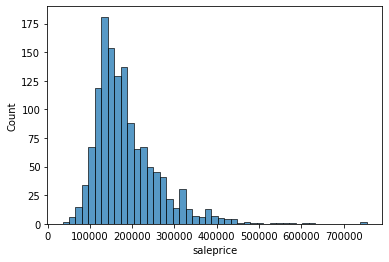

In [52]:
# your work here
sns.histplot(dummied_house.saleprice)
plt.show()

In [53]:
dummied_house.saleprice.describe()

count      1338.000000
mean     186761.782511
std       78913.847668
min       35311.000000
25%      135000.000000
50%      168500.000000
75%      220000.000000
max      755000.000000
Name: saleprice, dtype: float64

In [54]:
house_df = dummied_house.copy()
house_df.saleprice = np.log(house_df.saleprice)
house_df.saleprice.describe()

count    1338.000000
mean       12.063492
std         0.376848
min        10.471950
25%        11.813030
50%        12.034691
75%        12.301383
max        13.534473
Name: saleprice, dtype: float64

We know that there are some rare large values. We can make sure that the training and test sets have about the same distribution by stratifying the train-test split.

Split your training and test sets, with a test size of 0.2. Use the given helper function to stratify the continuous outcome. Remember that the outcome variable is now the **log of sale price**.

In [40]:
def binned(y, num_bins):
    # Creates an object to put in the stratify keyword in train_test_split
    # Specify number of bins to separate your y variable
    ymin, ymax = y.min(), y.max()
    bins = np.linspace(ymin, ymax, num_bins+1)[:-1]
    y_binned = np.digitize(y, bins)
    return y_binned

In [58]:
# your work here
from sklearn.model_selection import train_test_split

y = house_df.saleprice
X = house_df.drop(columns=['saleprice', 'id'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=binned(y,10))

Create a Gradient Boosting Regressor model. Measure the MAE (Mean Absolute Error) for the training and testing sets.

In [59]:
# your work here
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [62]:
from sklearn.metrics import mean_absolute_error

y_train_pred = gbr.predict(X_train) 
y_test_pred = gbr.predict(X_test)
print('Training Set MSE: {:.4f}'.format(mean_absolute_error(y_train, y_train_pred)))
print('Testing Set MSE: {:.4f}'.format(mean_absolute_error(y_test, y_test_pred)))

Training Set MSE: 0.0568
Testing Set MSE: 0.0816


Create a grid search. Try varying subsample, learning rate, and max features. Use MAE as your scoring metric.

In [72]:
# your work here
from sklearn.model_selection import GridSearchCV

ss = np.arange(0.25, 1, 0.25)
lr = np.arange(0.1, 0.8, 0.1)
param_grid = {
    "subsample": ss,
    "learning_rate": lr,
    "n_estimators": [1000],
    "max_features": ['auto', 'sqrt', 'log2'],
}

gbr_cv = GridSearchCV(gbr, param_grid, scoring='neg_mean_absolute_error', cv=5)

gbr_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...
                            

In [73]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",gbr_cv.best_estimator_)
print("\n The best score across ALL searched params:\n",gbr_cv.best_score_)
print("\n The best parameters across ALL searched params:\n",gbr_cv.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features='auto', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=0.75, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

 The best score across ALL searched params:
 -0.0845960761853066

 The best parameters across ALL searched params:
 {'learning_rate': 0.1, 'max_features': 'auto', 'n_estimators': 1000, 'subsample': 0.75}


In [74]:
best_results = gbr_cv.best_estimator_
y_train_pred = best_results.predict(X_train) 
y_test_pred = best_results.predict(X_test)

print('Training Set MSE: {:.4f}'.format(mean_absolute_error(y_train, y_train_pred)))
print('Testing Set MSE: {:.4f}'.format(mean_absolute_error(y_test, y_test_pred)))

print("Training R^2 Score: ", best_results.score(X_train, y_train))
print("Testing R^2 Score: ", best_results.score(X_test, y_test))

Training Set MSE: 0.0100
Testing Set MSE: 0.0778
Training Score:  0.9989178592345582
Testing Score:  0.9177312680550492


Create residual plots of the training and test sets and interpret your results.

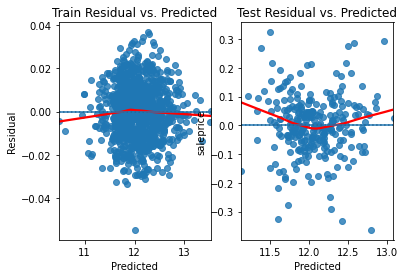

In [97]:
# your work here
train_predictions = y_train_pred
train_errors = y_train - y_train_pred

test_predictions = y_test_pred
test_errors = y_test - y_test_pred

plt.figure()
plt.subplot(121)
sns.residplot(x=train_predictions, y= train_errors, lowess=True, line_kws={'color':'red'})
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Train Residual vs. Predicted')

plt.subplot(122)
sns.residplot(x=test_predictions, y=test_errors, lowess=True, line_kws={'color':'red'})
plt.xlabel('Predicted')
plt.axhline(y=0)
plt.title('Test Residual vs. Predicted')
plt.show()

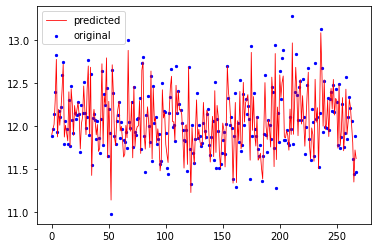

In [78]:
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, y_test_pred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

We definitely have overfitting occuring, which is evidenced by the graphs above and our high R^2 scores.